## Dag&Cat Object Detection with Yolov8

[Korean](01_garbage.ko-KR.ipynb) \| [English](01_garbage.en-US.ipynb) \| Copyright (c) 2023 [Jihoon Lucas Kim](https://github.com/kimnamu)

<a href="https://colab.research.google.com/github/kimnamu/cvnets/blob/master/demo/classfication/01_garbage.ko-KR.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

이 notebook은 Custom Dataset으로 Image Object Detection 모델을 학습하는 과정을 다루고 있습니다.

Custom Dataset을 다루기 전에 Pretrained 모델을 Inference 하는 실습을 진행합니다.

reference : [ultralytics](https://github.com/ultralytics/ultralytics), [Train YOLOv8 on Custom Data?](https://medium.com/augmented-startups/train-yolov8-on-custom-data-6d28cd348262)

## Process
1. Installation of Modules
2. Pretrained Object Detection
3. Train YOLOv8 on Custom Data
4. Inference with Custom Weights
5. Yolov8

## 1. Installation of Modules 

- YOLOv8은 아래에 언급된 명령어로 설치할 수 있는 "ultralytics"라는 패키지를 출시했습니다.
- 위의 명령은 자체 데이터에 대한 탐지 및 학습을 위해 YOLOv8을 사용하는 데 필요한 모든 패키지를 설치합니다.
- 시스템에 파이썬 3.7.0 이상이 설치되어 있는지 확인하세요.

In [ ]:
!pip install ultralytics  

## 2. Pretrained Object Detection

- 효율적인 방식으로 객체 감지를 수행하고 더 정확하고 빠른 속도로 결과를 제공할 수 있는 단일 명령을 실행해야 한다면 어떤 느낌이 드시나요?
- 터미널/(명령 프롬프트)에서 아래에 언급된 명령을 실행하여 YOLOv8을 사용하여 선택한 비디오/이미지에 대해 미리 학습된 가중치로 검출을 수행할 수 있습니다.
- 모든 것이 정상적으로 작동하면 "runs/detect/exp" 폴더 내의 현재 디렉터리에서 결과를 확인할 수 있습니다.


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /home/jovyan/models/ultralytics/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 12.1ms
Speed: 0.3ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


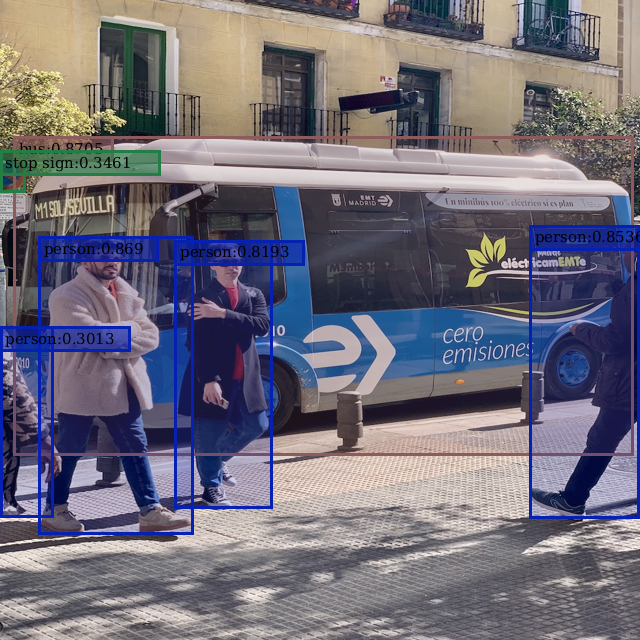

In [ ]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import yaml
np.random.seed(724)

with open('./ultralytics/datasets/coco.yaml') as f:
    coco = yaml.load(f, Loader=yaml.FullLoader)
    class_names = coco['names']

# # Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8n.pt')

# # Perform object detection on an image using the model
results = model('https://ultralytics.com/images/bus.jpg')

def draw_bbox(draw, bbox, label, color=(0, 255, 0, 255), confs=None, size=15):
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf", size)
    draw.rectangle(bbox, outline=color, width =3)
    def set_alpha(color, value):
        background = list(color)
        background[3] = value
        return tuple(background)
    background = set_alpha(color, 50)
    draw.rectangle(bbox, outline=color, fill=background, width =3)
    background = set_alpha(color, 150)
    text = f"{label}" + ("" if confs==None else f":{conf:0.4}")
    text_bbox = bbox[0], bbox[1], bbox[0]+len(text)*10, bbox[1]+25
    draw.rectangle(text_bbox, outline=color, fill=background, width =3)
    draw.text((bbox[0]+5, bbox[1]+5), text, (0,0,0), font=font)

color = []
n_classes = 80
for _ in range(n_classes):
    c = list(np.random.choice(range(256), size=3)) + [255]
    c = tuple(c)
    color.append(c)
    
img = Image.open("./bus.jpg")
img = img.resize((640, 640))
width, height = img.size
draw = ImageDraw.Draw(img, 'RGBA')

for result in results:
    result = result.cpu()
    # result.boxes.xyxy   # box with xyxy format, (N, 4)
    # result.boxes.xywh   # box with xywh format, (N, 4)
    xyxys = result.boxes.xyxyn  # box with xyxy format but normalized, (N, 4)
    # result.boxes.xywhn  # box with xywh format but normalized, (N, 4)
    confs = result.boxes.conf   # confidence score, (N, 1)
    clss = result.boxes.cls    # cls, (N, 1)

    xyxys = xyxys.numpy()
    clss = map(int, clss.numpy())
    for xyxy, conf, cls in zip(xyxys, confs, clss):
        xyxy = [xyxy[0]*width, xyxy[1]*height, xyxy[2]*width, xyxy[3]*height]
        draw_bbox(draw, bbox=xyxy, label=class_names[cls], color=color[cls], confs=confs, size=15)
    img.show()

## 3. Train Yolov8 on Custom Data

- 사용자 지정 데이터에 대한 YOLOv8 객체 감지 모델을 학습시키는 단계는 다음과 같이 요약할 수 있습니다.

    - 3.1 Collect data
    - 3.2 Label data
    - 3.3 Split data (train, test, and val)
    - 3.4 Creation of config files
    - 3.4 Start training

### 3.1 Collect Data

- coco dataset으로부터 원하는 subclass를 parsing하여 데이터셋을 구축합니다.
- 본 실습코드에서는 학습 데이터의 양과 학습시간을 고려해 coco train 데이터가 아닌 coco validation 데이터로 학습데이터를 구축합니다.
    - https://cocodataset.org/#download
- 다운받은 데이터는 아래 코드를 활용해 yolov8 학습 데이터 포멧으로 변환합니다.
    - [sub-class parsing](https://github.com/kimnamu/annotation/blob/main/coco/create_subclass.ipynb)
    - [convert yolo format](https://github.com/kimnamu/annotation/blob/main/coco/convert_yolo_label.ipynb)
- YOLOv8은 텍스트(.txt) 파일의 라벨 데이터를 사용하며 형식은 다음과 같습니다

    ```
    class x y width height
    ```

### 3.2 Split Data (Train, Test, and Val)

- 사용자 지정 데이터로 컴퓨터 비전 모델을 학습시키려면 데이터를 학습 세트와 테스트 세트로 분리하는 것이 중요합니다. 
- 학습 세트는 모델에 예측 방법을 가르치는 데 사용되며, 테스트 세트는 모델의 정확도를 평가하는 데 사용됩니다. 
- (80-20%)의 분할 비율은 일반적인 비율이지만, 정확한 비율은 데이터 집합의 크기와 작업 중인 특정 작업에 따라 달라질 수 있습니다. 
- 예를 들어, 데이터 세트가 작은 경우 훈련에 더 높은 비율을 사용하고, 데이터 세트가 큰 경우 훈련에 더 적은 비율을 사용할 수 있습니다.

- Folder structure

```
└── yolov8
    ├── train
    │   ├── images (folder including all training images)
    │   └── labels (folder including all training labels)
    ├── test
    │   ├── images (folder including all training images)
    │   └── labels (folder including all training labels)
    └── valid
        ├── images (folder including all training images)
        └── labels (folder including all training labels)
```


### 3.3 Creation of Config Files

- 사용자 지정 구성 파일을 생성하면 컴퓨터 비전 모델의 모든 중요한 매개 변수를 구성하고 저장하는 데 유용할 수 있습니다.
- 터미널/(명령 프롬프트)를 연 현재 디렉터리 내에 파일 이름이 "custom. yaml"인 파일을 생성합니다. 
- 해당 파일에 아래 코드를 붙여넣습니다. 데이터 세트 폴더의 올바른 경로를 설정하고 클래스 및 이름을 변경한 다음 저장합니다.

```
path:  (dataset directory path)
train: (Complete path to dataset train folder)
test: (Complete path to dataset test folder) 
valid: (Complete path to dataset valid folder)

#Classes
nc: 5# replace according to your number of classes

#classes names
#replace all class names list with your classes names
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane']
```

In [ ]:
config_txt = '''
path: ../datasets/coco/dog_cat  # dataset root dir

train: train/images # train images (relative to 'path')
val: test/images # val images (relative to 'path')
test:  test/images # test images (optional)

# Classes
names:
  0: dog # 18 coco class
  1: cat # 17 coco class
'''

with open("./ultralytics/datasets/dog_cat.yaml", 'w') as f:
    f.write(config_txt)

dataset을 만들때 class는 0부터 시작하도록 맵핑해서 만들어주어야 합니다.
아래 소스코드르 활용해서 만들어주세요.

https://github.com/kimnamu/annotation/blob/main/coco/convert_yolo_label.ipynb

트레이닝 프로세스는 해당 파일에 전적으로 의존하므로 트레이닝 및 테스트 디렉터리의 경로를 올바르게 설정해야 합니다.

### 3.4 Start Training

- 데이터 수집, 데이터 라벨링, 데이터 분할, 사용자 지정 구성 파일 생성 등의 전처리 단계를 완료했다면 이미지가 손상된 경우 사용자 지정 데이터에 대한 학습을 시작하지 않으며, 일부 레이블 파일이 손상된 경우 YOLOv8은 해당 (이미지 및 레이블) 파일을 무시하므로 학습에 아무런 문제가 없습니다.
- 훈련이 완료될 때까지 기다린 다음 새로 생성된 가중치로 추론을 수행합니다. 사용자 정의 학습된 가중치는 아래에 언급된 폴더 경로에 저장됩니다.
```
runs/train/exp/weights/best.pt
```



In [ ]:
from ultralytics import YOLO

# Create a new YOLO model from scratch
model = YOLO('yolov8n.yaml')

# Load a pretrained YOLO model (recommended for training)
model = YOLO('yolov8n.pt')

# Train the model using the 'indoor.yaml' dataset for 10 epochs
results = model.train(data='dog_cat.yaml', epochs=10)

# Evaluate the model's performance on the validation set
results = model.val()


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

## 4. Inference with Custom Weights

- 모델이 학습되면 이를 사용하여 새 데이터에 대한 예측을 할 수 있습니다. 사용자 지정 가중치를 사용하여 탐지하려면 아래에 언급된 명령을 사용하세요.



0: 640x640 1 cat, 1: 640x640 1 dog, 2: 640x640 1 dog, 3: 640x640 1 cat, 4: 640x640 1 dog, 19.7ms
Speed: 0.2ms preprocess, 3.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


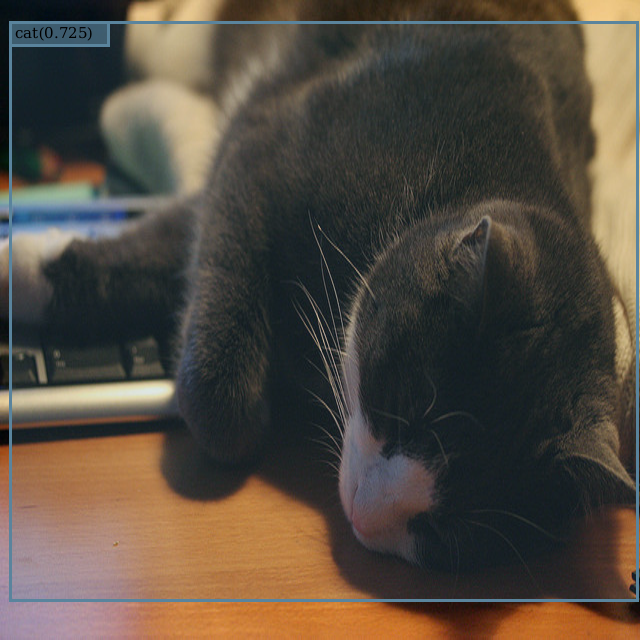

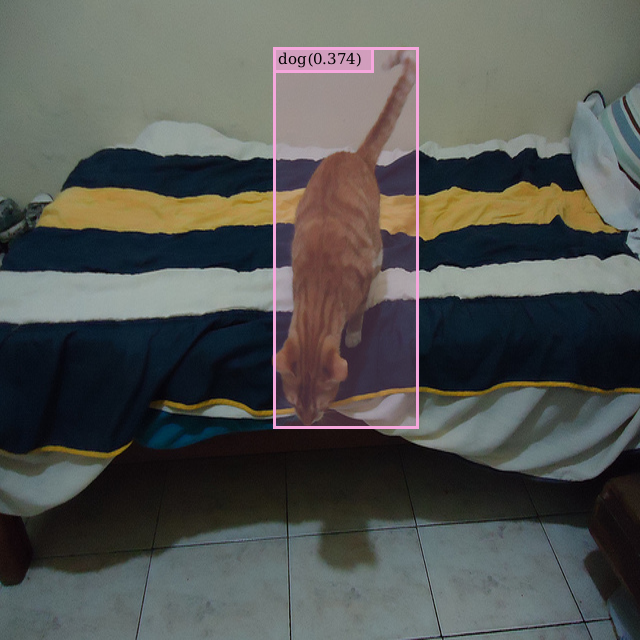

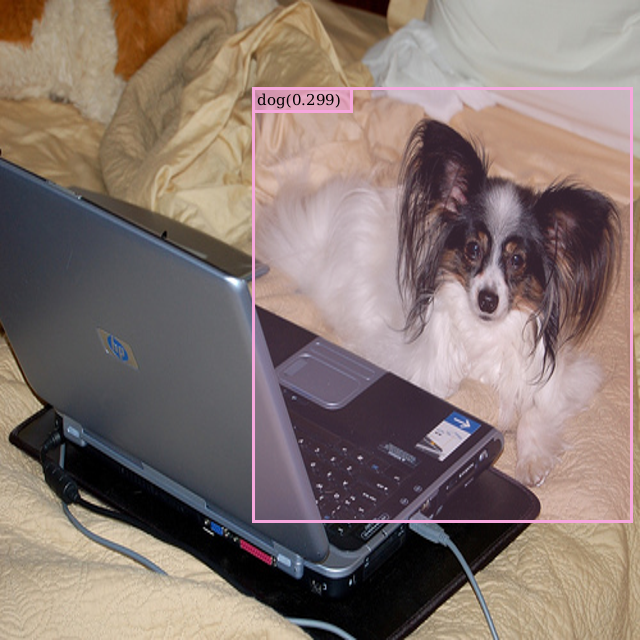

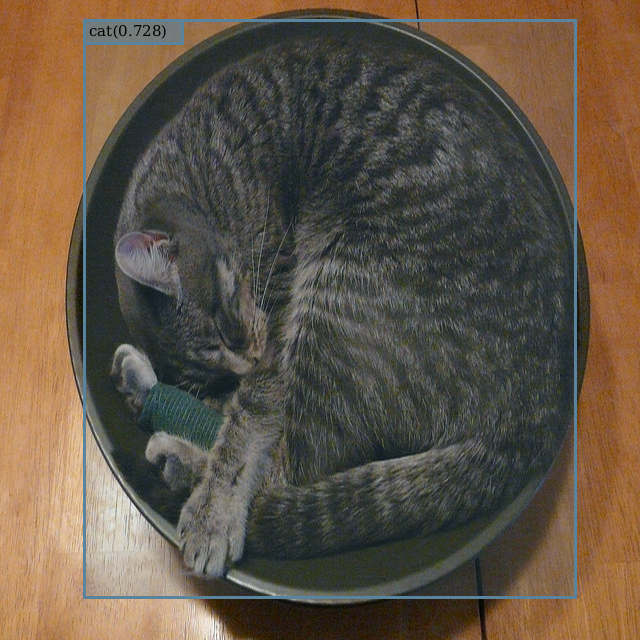

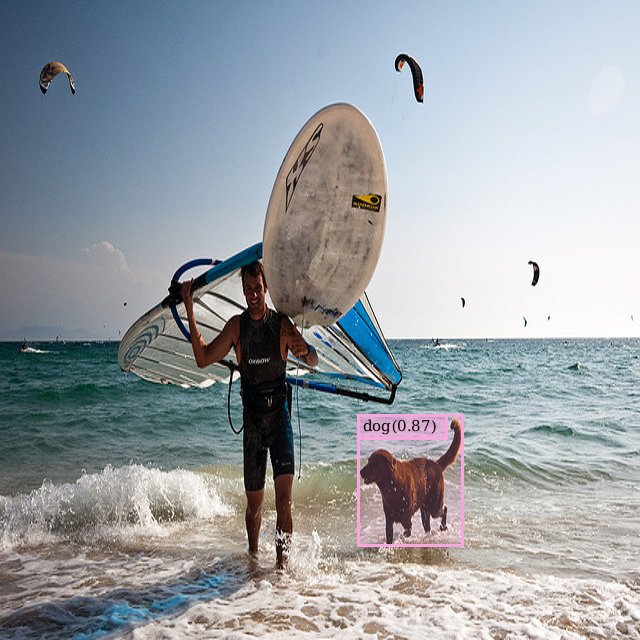

In [ ]:
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from glob import glob
import yaml
import numpy as np
np.random.seed(724)

# Load a model
model = YOLO('runs/detect/train20/weights/best.pt')
classes = ["dog", "cat"]

# Load images
filelist = glob("./ultralytics/yolo/data/scripts/datasets/coco/dog_cat//test/images/*.jpg")
filelist = np.random.choice(filelist, size=5)
imgs = [Image.open(filename) for filename in filelist]

# Perform object detection on an image using the model
results = model(imgs)

def draw_bbox(draw, bbox, label, color=(0, 255, 0, 255), confs=None, size=12):
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf", size)
    draw.rectangle(bbox, outline=color, width =3)
    def set_alpha(color, value):
        background = list(color)
        background[3] = value
        return tuple(background)
    background = set_alpha(color, 50)
    draw.rectangle(bbox, outline=color, fill=background, width =3)
    background = set_alpha(color, 150)
    text = f"{label}" + ("" if confs==None else f"({conf:0.3})")
    text_bbox = bbox[0], bbox[1], bbox[0]+len(text)*10, bbox[1]+25
    draw.rectangle(text_bbox, outline=color, fill=background, width =3)
    draw.text((bbox[0]+5, bbox[1]+5), text, (0,0,0), font=font)

color = []
n_classes = len(classes)
for _ in range(n_classes):
    c = list(np.random.choice(range(256), size=3)) + [255]
    c = tuple(c)
    color.append(c)
    
for img, result in zip(imgs, results):
    img = img.resize((640, 640))
    width, height = img.size
    draw = ImageDraw.Draw(img, 'RGBA')
    result = result.cpu()
    xyxys = result.boxes.xyxyn  # box with xyxy format but normalized, (N, 4)
    confs = result.boxes.conf   # confidence score, (N, 1)
    clss = result.boxes.cls    # cls, (N, 1)

    xyxys = xyxys.numpy()
    clss = map(int, clss.numpy())
    for xyxy, conf, cls in zip(xyxys, confs, clss):
        xyxy = [xyxy[0]*width, xyxy[1]*height, xyxy[2]*width, xyxy[3]*height]
        draw_bbox(draw, bbox=xyxy, label=classes[cls], color=color[cls], confs=confs, size=15)
    img.show()

## 5. What is YOLOv8?

- YOLOv8은 객체 탐지(Object Detection), 이미지 분류(Image Classification), 인스턴스 분할(Instance Segmentation) 작업에 사용할 수 있는 최신 기술의 YOLO 모델입니다. YOLOv8은 영향력 있는 YOLOv5 모델을 개발한 [Ultralytics](https://ultralytics.com/?ref=blog.roboflow.com)에 의해 개발되었습니다. YOLOv8은 YOLOv5와 비교하여 수많은 구조적 및 개발자 경험의 변화와 개선 사항을 포함하고 있습니다.

- YOLOv8은 이 글을 쓰는 시점에서 Ultralytics가 새로운 기능을 개발하고 커뮤니티로부터의 피드백에 응답하면서 활발한 개발이 진행되고 있습니다. 실제로 Ultralytics가 모델을 출시하면 장기적인 지원을 받게 됩니다. 이 기관은 커뮤니티와 협력하여 모델을 최상의 상태로 만들기 위해 노력합니다.

### How YOLO Grew Into YOLOv8

- [YOLO(You Only Look Once)](https://blog.roboflow.com/guide-to-yolo-models/) 모델 시리즈는 컴퓨터 비전 계열에서 매우 유명한 모델입니다. YOLO은 높은 정확도를 유지하면서 기존의 2-stage방식이 아닌 1-stage 방식의 경량화된 아키텍쳐를 가진 덕분입니다. YOLO 모델은 단일 GPU에서 학습할 수 있어 다양한 개발자들에게 접근하기 쉽습니다. 머신러닝 전문가들은 저렴한 비용으로 엣지 하드웨어나 클라우드에 배포할 수 있습니다.

<center><img src = "https://drive.google.com/uc?id=1UFaYbWo2yt5POIA76fC6hzpbTsg4Nmaj"  height = 300> </center>

- YOLO는 2015년 Joseph Redmond가 처음 출시한 이후 컴퓨터 비전 커뮤니티에 의해 성장해왔습니다. 초기 버전(1-4)에서는 YOLO가 Redmond가 작성한 커스텀 딥러닝 프레임워크인 [Darknet](https://blog.roboflow.com/training-yolov4-on-a-custom-dataset/)에서 C 코드로 유지되었습니다.

- Ultralytics의 Glenn Jocher는 [YOLOv3 레포](https://blog.roboflow.com/training-a-yolov3-object-detection-model-with-a-custom-dataset/)를 PyTorch(Facebook에서 만든 딥러닝 프레임워크)로 따라했습니다. 그림자 레포에서 학습이 더 나아지자 Ultralytics는 결국 자체 모델인 [YOLOv5](https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/)를 출시했습니다.

- 유연한 Python 구조 덕분에 YOLOv5는 빠르게 세계의 SOTA 레포가 되었습니다. 이 구조는 커뮤니티가 새로운 모델링 개선 사항을 발명하고 유사한 PyTorch 방법으로 레포 전체에 빠르게 공유할 수 있게 했습니다.

<center><img src = "https://drive.google.com/uc?id=1r7rzcrQlzoItoqpHdSDNdv-lGAxnD6lS"  height = 300> </center>

- 강력한 기초 모델과 함께 YOLOv5 관리자들은 모델을 둘러싼 건강한 소프트웨어 생태계를 지원하는 데 전념했습니다. 그들은 적극적으로 문제를 해결하고 커뮤니티의 요구에 따라 레포의 기능을 향상시켰습니다.

- 지난 두 해 동안, YOLOv5 PyTorch 레포에서 다양한 모델들이 파생되었으며, [Scaled-YOLOv4](https://roboflow.com/model/scaled-yolov4?ref=blog.roboflow.com), [YOLOR](https://blog.roboflow.com/train-yolor-on-a-custom-dataset/), [YOLOv7](https://blog.roboflow.com/yolov7-breakdown/) 등이 포함됩니다. [YOLOX](https://blog.roboflow.com/how-to-train-yolox-on-a-custom-dataset/) 및 [YOLOv6](https://blog.roboflow.com/how-to-train-yolov6-on-a-custom-dataset/)와 같은 다른 모델들은 각자의 PyTorch 기반 구현에서 세계적으로 등장했습니다. 이 과정에서 각 YOLO 모델은 모델의 정확도와 효율성을 향상시키는 새로운 SOTA 기술을 가져왔습니다.

- 최근 6개월 동안, Ultralytics는 최신 SOTA 버전인 YOLOv8을 연구하는 데 집중했습니다. YOLOv8은 2023년 1월 10일에 출시되었습니다. 이 모델은 이전 YOLO 버전들의 효율성과 정확도를 향상시킨 새로운 기술을 결합하여 더욱 강력한 객체 탐지 및 인스턴스 분할 성능을 제공합니다. 또한, YOLOv8은 사용자 친화적인 API와 확장성 있는 구조를 제공하여 더 많은 개발자들이 이 모델을 쉽게 적용하고 수정할 수 있게 되었습니다.

- YOLOv8은 계속해서 발전하고 있으며, Ultralytics 및 커뮤니티는 이 모델을 개선하기 위해 지속적으로 협력하고 있습니다. 이렇게 함으로써 YOLO 시리즈는 앞으로도 컴퓨터 비전 분야에서 지속적으로 중요한 역할을 하게 될 것입니다.

### YOLOv8 Architecture: A Deep Dive

- YOLOv8에는 아직 발표된 논문이 없어, 이 모델을 만드는 과정에서 수행된 연구 방법론과 Ablation 연구에 대한 직접적인 통찰력이 부족합니다. 그렇지만 레포지토리와 모델에 대한 정보를 분석하여 YOLOv8의 새로운 점들을 문서화하기 시작했습니다.

- 직접 코드를 살펴보고 싶다면, YOLOv8 레포지토리를 확인하고 이 코드 차이점을 확인하여 일부 연구가 어떻게 이루어졌는지 알아볼 수 있습니다.

- 여기에 영향력 있는 모델링 업데이트에 대한 간단한 요약을 제공하고, 이어서 모델의 평가 결과를 살펴보겠습니다. 이 결과는 모델의 성능을 직접 보여주기 때문입니다.

- 아래 이미지는 GitHub 사용자 RangeKing이 만든 것으로, 네트워크 아키텍처의 상세한 시각화를 보여줍니다.

<center><img src = "https://drive.google.com/uc?id=1rF9P8KF_GvQSBFN0bDOX3fi_CH6Bq8yZ"  height = 800> </center>

### Anchor Free Detection

- YOLOv8은 앵커 프리(Anchor-free) 모델입니다. 이는 객체의 중심을 직접 예측하며, 알려진 [Anchor Box](https://blog.roboflow.com/what-is-an-anchor-box/)에서의 오프셋이 아닙니다.

<center><img src = "https://drive.google.com/uc?id=1KCiwml2dJ66c2ZpSdIqFG2j13SpxMVp5"  height = 300> </center>

- [Anchor Box](https://blog.roboflow.com/what-is-an-anchor-box/)는 이전 YOLO 모델에서 굉장히 까다로운 부분이었는데, 이는 대상 벤치마크 박스의 분포를 나타낼 수 있지만 사용자 정의 데이터셋의 분포는 아닐 수 있기 때문입니다.

<center><img src = "https://drive.google.com/uc?id=1V3q1MN_p3UK3d-hFSSbG2Sz1ydO8cLdE"  height = 300> </center>

Anchor free detection은 박스 예측의 수를 줄여, Non-Maximum Suppression(NMS)라는 복잡한 후처리 단계를 가속화합니다. NMS는 추론 후 후보 탐지 결과를 걸러내는 과정입니다.

<center><img src = "https://drive.google.com/uc?id=1Z2_Oi3c7XWTMkgX2I3AQf8lyV6JIEj-y"  height = 300> </center>

### Closing the Mosaic Augmentation

- 딥러닝 연구는 대체로 모델 아키텍처에 초점을 맞추는 경향이 있지만, YOLOv5와 YOLOv8의 훈련 루틴은 그들의 성공에 있어 핵심적인 부분입니다.
- YOLOv8은 온라인에서 훈련 중 이미지를 증강시킵니다. 각 에폭마다 모델은 제공된 이미지의 약간 다른 변형을 확인합니다.
- 이러한 증강 중 하나는 모자이크 증강이라고 불립니다. 이는 4개의 이미지를 함께 이어붙여서 모델이 새로운 위치에서 객체를 학습하고, 부분 가림이 있는 상태에서, 그리고 다른 주변 픽셀에 대해 학습하도록 강제하는 것입니다.

<center><img src = "https://drive.google.com/uc?id=1DDML0TPqA3Oli54ZCcN4fN4xsMfjqE08"  height = 300> </center>

- 그러나 이러한 증강은 전체 훈련 루틴을 거치는 동안 수행되면 성능이 저하되는 것으로 경험적으로 입증되었습니다. 마지막 10개의 훈련 에폭에 대해서는 이를 끄는 것이 유리합니다.

- 이러한 변화는 YOLOv5 레포에서의 YOLO 모델링에 지속적으로 신경을 쓰고 있는 것과 YOLOv8 연구에서의 주의를 기울이는 예시입니다.

### YOLOv8 Accuracy Improvements

- YOLOv8 연구는 주로 [COCO 벤치마크](https://blog.roboflow.com/coco-dataset/)에 대한 경험적 평가에 의해 동기를 부여받았습니다. 네트워크와 훈련 루틴의 각 부분이 조정됨에 따라, COCO 모델링에 대한 변경 효과를 검증하기 위해 새로운 실험이 진행됩니다.

- COCO(Common Objects in Context)는 객체 감지 모델을 평가하는 업계 표준 벤치마크입니다. COCO에서 모델을 비교할 때, mAP 값과 추론 속도를 측정하는 FPS를 참조합니다. 모델은 유사한 추론 속도에서 비교해야 합니다.

- 아래 이미지는 Ultralytics 팀이 수집한 데이터를 사용하여 COCO에서의 YOLOv8 정확도를 보여주며, [YOLOv8 README](https://github.com/ultralytics/ultralytics?ref=blog.roboflow.com)에 게시되어 있습니다.

<center><img src = "https://drive.google.com/uc?id=1L7k4EuJzlvhCfRYpQ4Cb1Y27XNoxptu7"  height = 300> </center>

#### Yolov8 vs Yolov7 vs Yolov6 vs Yolov5 ([참조](https://learnopencv.com/ultralytics-yolov8/))

- 당장 YOLOv8 모델은 이전 YOLO 모델에 비해 훨씬 더 나은 성능을 보이는 것 같습니다. YOLOv5 모델뿐만 아니라 YOLOv8 모델도 YOLOv7 및 YOLOv6 모델에 비해 앞서고 있습니다.

<center><img src = "https://drive.google.com/uc?id=15TdSaz1NLh11o2LIUIQZ_ZzuzrV3KXcz"  height = 300> </center>

<center><img src = "https://drive.google.com/uc?id=1_d5zK0eMY389E4PRzuJm5N98SIXaYbsV"  height = 300> </center>